# Basic Version w/ Freeze Learning & Fine-tuning
For this approach, it will be used a pretrained DenseNet201, to which we will apply freeze learning and fine-tuning for our task.

In [1]:
import os

DATA_DIR = "../data/"
IMG_DIR = DATA_DIR + "/images/"
ANNOTATION_DIR = DATA_DIR + "/annotations/"
SPLITS_DIR = DATA_DIR + "/dl-split/"
OUT_DIR = "./out/basic_custom/"

os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42

# Utility Function

In [2]:
import matplotlib.pyplot as plt
def plot_training_history(train_history, val_history, model_name, phase_name, out_dir):
    fig, (loss_ax, acc_ax) = plt.subplots(figsize=(12, 8), nrows=2)
    fig.suptitle(f"{model_name} - {phase_name} History")
    loss_ax.set_title("Cross Entropy Loss")
    loss_ax.plot(train_history["loss"], label="train")
    loss_ax.plot(val_history["loss"], label="val")
    loss_ax.legend(loc="best")

    acc_ax.set_title("Classification accuracy")
    acc_ax.plot(train_history["accuracy"], label="train")
    acc_ax.plot(val_history["accuracy"], label="val")
    loss_ax.legend(loc="best")

    plt.tight_layout()

    fig.savefig(f"{out_dir}/{model_name}_{phase_name}_history.png", dpi=150, bbox_inches='tight')

    return fig

## Load Dataset

In [3]:
# Fetching pre-defined splits
train_split = []
test_split = []

with open(SPLITS_DIR + "/train.txt") as train_split_f:
    train_split = [line.strip("\n") for line in train_split_f.readlines()]

with open(SPLITS_DIR + "/test.txt") as test_split_f:
    test_split = [line.strip("\n") for line in test_split_f.readlines()]

In [4]:
# Label mapping
label_encode_map = {
    "background": -100,
    "trafficlight": 0,
    "speedlimit": 1,
    "crosswalk": 2,
    "stop": 3,
}

label_decode_map = {
    -100: "background",
    0: "trafficlight",
    1: "speedlimit",
    2: "crosswalk",
    3: "stop",
}

# Cull training dataset to balance classes better

In [5]:
from utils.utils import parse_annotation

def get_annotations(split):
    annotations = {}
    for id in split:
        annotation = parse_annotation(f"{ANNOTATION_DIR}/{id}.xml", label_encode_map, return_biggest = True)
        annotation["labels"] = annotation["labels"][0]
        annotations[id] = annotation

    return annotations

annotations = get_annotations(train_split)

In [6]:
import pandas as pd
train_df = pd.DataFrame.from_dict(annotations, orient="index")
train_df

,width,height,labels,boxes,areas
road706,300.0,400.0,1,"[[135.0, 159.0, 177.0, 201.0]]",[1764.0]
road538,300.0,400.0,1,"[[115.0, 169.0, 149.0, 205.0]]",[1224.0]
road510,300.0,400.0,1,"[[89.0, 201.0, 133.0, 245.0]]",[1936.0]
road504,300.0,400.0,1,"[[92.0, 230.0, 139.0, 277.0]]",[2209.0]
road458,300.0,400.0,1,"[[67.0, 116.0, 139.0, 189.0]]",[5256.0]
...,...,...,...,...,...
road247,300.0,400.0,1,"[[139.0, 218.0, 156.0, 236.0]]",[306.0]
road253,300.0,400.0,1,"[[128.0, 87.0, 187.0, 144.0]]",[3363.0]
road535,300.0,400.0,1,"[[100.0, 254.0, 180.0, 334.0]]",[6400.0]
road284,300.0,400.0,1,"[[111.0, 133.0, 165.0, 187.0]]",[2916.0]


Label Ratios
0    0.086460
1    0.730832
2    0.104405
3    0.078303
Name: labels, dtype: float64


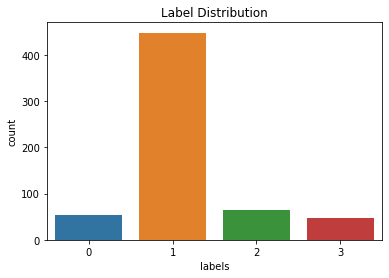

<Figure size 432x288 with 0 Axes>

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Label Ratios")
label_ratios = (train_df["labels"].value_counts() / len(train_df["labels"])).sort_index()
print(label_ratios)

fig, ax = plt.subplots()
sns.countplot(data=train_df, x="labels", ax=ax, tick_label=["trafficlight", "speedlimit", "crosswalk", "stop"])
ax.set_title("Label Distribution")

plt.show()
plt.clf()

In [8]:
import numpy as np
non_max_labels = label_ratios[label_ratios != label_ratios.max()]
ratio_to_return = np.sum(non_max_labels) + np.max(non_max_labels)

print(f"Ratio of training dataset to return: {ratio_to_return}")

Ratio of training dataset to return: 0.3735725938009788


In [9]:
weights = (1 - label_ratios) / np.sum(1 - label_ratios)
print("Weights")
print(weights)
train_df["weights"] = 0
for i, weight in enumerate(weights):
    train_df.loc[train_df["labels"] == i, "weights"] = weight / len(train_df[train_df["labels"] == i])

train_df

Weights
0    0.304513
1    0.089723
2    0.298532
3    0.307232
Name: labels, dtype: float64


,width,height,labels,boxes,areas,weights
road706,300.0,400.0,1,"[[135.0, 159.0, 177.0, 201.0]]",[1764.0],0.0002
road538,300.0,400.0,1,"[[115.0, 169.0, 149.0, 205.0]]",[1224.0],0.0002
road510,300.0,400.0,1,"[[89.0, 201.0, 133.0, 245.0]]",[1936.0],0.0002
road504,300.0,400.0,1,"[[92.0, 230.0, 139.0, 277.0]]",[2209.0],0.0002
road458,300.0,400.0,1,"[[67.0, 116.0, 139.0, 189.0]]",[5256.0],0.0002
...,...,...,...,...,...,...
road247,300.0,400.0,1,"[[139.0, 218.0, 156.0, 236.0]]",[306.0],0.0002
road253,300.0,400.0,1,"[[128.0, 87.0, 187.0, 144.0]]",[3363.0],0.0002
road535,300.0,400.0,1,"[[100.0, 254.0, 180.0, 334.0]]",[6400.0],0.0002
road284,300.0,400.0,1,"[[111.0, 133.0, 165.0, 187.0]]",[2916.0],0.0002


Label Ratios
0    0.227074
1    0.292576
2    0.270742
3    0.209607
Name: labels, dtype: float64


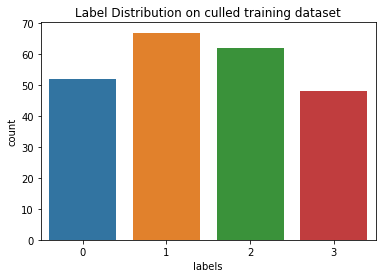

,width,height,labels,boxes,areas,weights
road40,267.0,400.0,0,"[[49.0, 4.0, 77.0, 74.0]]",[1960.0],0.005746
road495,300.0,400.0,2,"[[129.0, 200.0, 190.0, 260.0]]",[3660.0],0.004665
road637,300.0,400.0,3,"[[122.0, 88.0, 211.0, 175.0]]",[7743.0],0.006401
road71,400.0,301.0,3,"[[58.0, 55.0, 203.0, 203.0]]",[21460.0],0.006401
road20,320.0,400.0,0,"[[131.0, 135.0, 190.0, 271.0]]",[8024.0],0.005746
...,...,...,...,...,...,...
road241,300.0,400.0,1,"[[156.0, 201.0, 175.0, 220.0]]",[361.0],0.000200
road609,300.0,400.0,1,"[[57.0, 222.0, 92.0, 259.0]]",[1295.0],0.000200
road716,300.0,400.0,1,"[[150.0, 210.0, 169.0, 229.0]]",[361.0],0.000200
road664,300.0,400.0,1,"[[85.0, 200.0, 157.0, 273.0]]",[5256.0],0.000200


<Figure size 432x288 with 0 Axes>

In [10]:
culled_df = train_df.sample(frac=ratio_to_return, weights="weights", random_state=SEED)
print("Label Ratios")
label_ratios = (culled_df["labels"].value_counts() / len(culled_df["labels"])).sort_index()
print(label_ratios)

fig, ax = plt.subplots()
sns.countplot(data=culled_df, x="labels", ax=ax, tick_label=["trafficlight", "speedlimit", "crosswalk", "stop"])
ax.set_title("Label Distribution on culled training dataset")

plt.show()
plt.clf()

culled_df

In [11]:
culled_train_split = culled_df.index.tolist()

In [12]:
from datasets.road_sign_dataset import RoadSignDataset

# Training dataset
training_data = RoadSignDataset(
    img_names=culled_train_split,
    img_dir=IMG_DIR,
    annotation_dir=ANNOTATION_DIR,
    classes=label_encode_map,
    is_train=True,
    multilabel=False
)

# Test dataset
testing_data = RoadSignDataset(
    img_names=test_split,
    img_dir=IMG_DIR,
    annotation_dir=ANNOTATION_DIR,
    classes=label_encode_map,
    is_train=False,
    multilabel=False,
)

# Split training dataset into train and validation splits

In [13]:
import numpy as np
from torch.utils.data import SubsetRandomSampler

np.random.seed(SEED)

train_indices = list(range(len(training_data)))
np.random.shuffle(train_indices)
train_val_split = int(np.floor(0.2 * len(train_indices)))

train_idx, val_idx = train_indices[train_val_split:], train_indices[:train_val_split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

# Create Dataloaders

In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8 # Tested on 1050TI with 4GB (can load at least 64 as well, but doesn't make sense to use 64 with low amount of data)
NUM_WORKERS = 4

train_dataloader = DataLoader(
    dataset=training_data,
    sampler=train_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False, # Must be False because we're using a random sampler already
    drop_last=True,
    collate_fn=training_data.collate_fn
)

val_dataloader = DataLoader(
    dataset=training_data,
    sampler=val_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False, # Must be False because we're using a random sampler already
    drop_last=True,
    collate_fn=training_data.collate_fn
)

test_dataloader = DataLoader(
    dataset=testing_data,
    batch_size=1,
    num_workers=NUM_WORKERS,
    shuffle=False,
    drop_last=False,
    collate_fn=testing_data.collate_fn
)

# Model Definition

In [15]:
from models.TrafficSignifier import TrafficSignifier
from torch import nn
from torchinfo import summary

MODEL_NAME = "BASIC_CUSTOM"
N_CLASSES = 4

def get_model():
    return TrafficSignifier(
        num_classes=N_CLASSES,
        num_blocks=4,
        num_internal_layers=3,
    )

model = get_model()

summary(model)

Layer (type:depth-idx)                                  Param #
TrafficSignifier                                        --
├─Sequential: 1-1                                       --
│    └─_TrafficSignifierConv2d: 2-1                     --
│    │    └─Conv2d: 3-1                                 896
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─GELU: 3-3                                   --
│    └─_TrafficSignifierConv2d: 2-2                     --
│    │    └─Conv2d: 3-4                                 18,496
│    │    └─BatchNorm2d: 3-5                            128
│    │    └─GELU: 3-6                                   --
│    └─_TrafficSignifierConv2d: 2-3                     --
│    │    └─Conv2d: 3-7                                 36,928
│    │    └─BatchNorm2d: 3-8                            128
│    │    └─GELU: 3-9                                   --
│    └─GELU: 2-4                                        --
│    └─MaxPool2d: 2-5                   

# Define Optimizer, LR Scheduler, Loss function and Metric Scorer

In [16]:
from torch import optim
import torchmetrics

optimizer = optim.Adam(
    params=model.parameters(),
    lr=1e-2,
    betas=(0.9, 0.999),
    weight_decay=5e-4,
    amsgrad=True
)

lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer,
    gamma=0.99,
    verbose=True
)

loss_fn = nn.CrossEntropyLoss(ignore_index=label_encode_map["background"])

metric_scorer = torchmetrics.Accuracy(
    threshold=0.5,
    num_classes=N_CLASSES,
    average="micro",
    ignore_index=label_encode_map["background"]
)

Adjusting learning rate of group 0 to 1.0000e-02.


# Define Epoch Iteration

In [17]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def epoch_iter(dataloader, model, loss_fn, device, is_train = True, optimizer=None, lr_scheduler=None):
    if is_train:
        assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
        model.train()
    else:
        model.eval()

    probs = []
    preds = []
    expected_labels = []
    imageIds = []

    total_loss = 0.0

    with torch.set_grad_enabled(is_train):
        for _batch, (X, y) in enumerate(tqdm(dataloader)):
            labels = y["labels"]
            ids = y["imageIds"]

            X, y = X.to(device), labels.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            total_loss += loss.item()

            prob = F.softmax(pred, dim=1)
            final_pred = torch.argmax(prob, dim=1)

            probs.extend(prob.detach().cpu().numpy())
            preds.extend(final_pred.detach().cpu().numpy())
            expected_labels.extend(y.detach().cpu().numpy())
            imageIds.extend([f"road{imageId}" for imageId in ids.detach().cpu().numpy()])

        if is_train and lr_scheduler is not None:
            lr_scheduler.step()
    

    return (expected_labels, preds, probs, imageIds), total_loss / num_batches

# Train Model

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda:0


In [19]:
NUM_EPOCHS = 50

model.to(device)    
# model.features.requires_grad_(False) # Freeze feature layer

train_history = {
    "loss": [],
    "accuracy": [],
}

val_history = {
    "loss": [],
    "accuracy": [],
}

best_val_loss = np.inf
best_val_accuracy = 0
best_epoch = -1

print(f"Starting {MODEL_NAME} training...")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{NUM_EPOCHS}]")
    (train_target, train_preds, train_probs, _), train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device,
        is_train=True,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler
    )

    train_accuracy = metric_scorer(torch.tensor(np.array(train_probs)), torch.tensor(np.array(train_target))).item()
    print(f"Training loss: {train_loss:.3f}\t Training micro accuracy: {train_accuracy:.3f}")

    (val_target, val_preds, val_probs, _), val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device,
        is_train=False,
    )

    val_accuracy = metric_scorer(torch.tensor(np.array(val_probs)), torch.tensor(np.array(val_target))).item()
    print(f"Validation loss: {val_loss:.3f}\t Validation micro accuracy: {val_accuracy:.3f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        save_dict = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "lr_scheduler": lr_scheduler.state_dict(), "epoch": epoch}
        torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_best_model.pth")

    # Save latest model
    save_dict = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "lr_scheduler": lr_scheduler.state_dict(), "epoch": epoch}
    torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_latest_model.pth")

    # Save loss and accuracy in history
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_accuracy)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_accuracy)

    print("----------------------------------------------------------------")

print(
    f"\nFinished training..."
    f"\nBest epoch: {best_epoch}\t Validation loss on best epoch: {best_val_loss}\t Accuracy on best epoch: {best_val_accuracy}"
)

Starting BASIC_CUSTOM training...
Epoch[1/50]


100%|██████████| 23/23 [00:17<00:00,  1.35it/s]


Adjusting learning rate of group 0 to 9.9000e-03.
Training loss: 1.804	 Training micro accuracy: 0.355


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Validation loss: 6.844	 Validation micro accuracy: 0.222
----------------------------------------------------------------
Epoch[2/50]


100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Adjusting learning rate of group 0 to 9.8010e-03.
Training loss: 1.454	 Training micro accuracy: 0.380


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Validation loss: 1.744	 Validation micro accuracy: 0.389
----------------------------------------------------------------
Epoch[3/50]


100%|██████████| 23/23 [00:14<00:00,  1.61it/s]


Adjusting learning rate of group 0 to 9.7030e-03.
Training loss: 1.343	 Training micro accuracy: 0.423


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Validation loss: 1.676	 Validation micro accuracy: 0.394
----------------------------------------------------------------
Epoch[4/50]


100%|██████████| 23/23 [00:14<00:00,  1.61it/s]


Adjusting learning rate of group 0 to 9.6060e-03.
Training loss: 1.444	 Training micro accuracy: 0.423


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Validation loss: 1.820	 Validation micro accuracy: 0.429
----------------------------------------------------------------
Epoch[5/50]


100%|██████████| 23/23 [00:14<00:00,  1.60it/s]


Adjusting learning rate of group 0 to 9.5099e-03.
Training loss: 1.421	 Training micro accuracy: 0.393


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Validation loss: 1.656	 Validation micro accuracy: 0.400
----------------------------------------------------------------
Epoch[6/50]


100%|██████████| 23/23 [00:14<00:00,  1.58it/s]


Adjusting learning rate of group 0 to 9.4148e-03.
Training loss: 1.307	 Training micro accuracy: 0.401


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Validation loss: 1.584	 Validation micro accuracy: 0.432
----------------------------------------------------------------
Epoch[7/50]


100%|██████████| 23/23 [00:14<00:00,  1.58it/s]


Adjusting learning rate of group 0 to 9.3207e-03.
Training loss: 1.273	 Training micro accuracy: 0.458


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Validation loss: 1.378	 Validation micro accuracy: 0.353
----------------------------------------------------------------
Epoch[8/50]


100%|██████████| 23/23 [00:14<00:00,  1.55it/s]


Adjusting learning rate of group 0 to 9.2274e-03.
Training loss: 1.309	 Training micro accuracy: 0.467


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Validation loss: 1.187	 Validation micro accuracy: 0.486
----------------------------------------------------------------
Epoch[9/50]


100%|██████████| 23/23 [00:15<00:00,  1.47it/s]


Adjusting learning rate of group 0 to 9.1352e-03.
Training loss: 1.255	 Training micro accuracy: 0.444


100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation loss: 1.383	 Validation micro accuracy: 0.459
----------------------------------------------------------------
Epoch[10/50]


100%|██████████| 23/23 [00:14<00:00,  1.61it/s]


Adjusting learning rate of group 0 to 9.0438e-03.
Training loss: 1.227	 Training micro accuracy: 0.470


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Validation loss: 1.439	 Validation micro accuracy: 0.500
----------------------------------------------------------------
Epoch[11/50]


100%|██████████| 23/23 [00:14<00:00,  1.61it/s]


Adjusting learning rate of group 0 to 8.9534e-03.
Training loss: 1.299	 Training micro accuracy: 0.415


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Validation loss: 1.342	 Validation micro accuracy: 0.528
----------------------------------------------------------------
Epoch[12/50]


100%|██████████| 23/23 [00:14<00:00,  1.63it/s]


Adjusting learning rate of group 0 to 8.8638e-03.
Training loss: 1.264	 Training micro accuracy: 0.453


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Validation loss: 1.177	 Validation micro accuracy: 0.417
----------------------------------------------------------------
Epoch[13/50]


100%|██████████| 23/23 [00:15<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.7752e-03.
Training loss: 1.210	 Training micro accuracy: 0.491


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Validation loss: 1.529	 Validation micro accuracy: 0.382
----------------------------------------------------------------
Epoch[14/50]


100%|██████████| 23/23 [00:15<00:00,  1.53it/s]


Adjusting learning rate of group 0 to 8.6875e-03.
Training loss: 1.249	 Training micro accuracy: 0.449


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation loss: 1.013	 Validation micro accuracy: 0.471
----------------------------------------------------------------
Epoch[15/50]


100%|██████████| 23/23 [00:15<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.6006e-03.
Training loss: 1.210	 Training micro accuracy: 0.441


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Validation loss: 1.135	 Validation micro accuracy: 0.529
----------------------------------------------------------------
Epoch[16/50]


100%|██████████| 23/23 [00:14<00:00,  1.61it/s]


Adjusting learning rate of group 0 to 8.5146e-03.
Training loss: 1.200	 Training micro accuracy: 0.494


100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Validation loss: 1.346	 Validation micro accuracy: 0.394
----------------------------------------------------------------
Epoch[17/50]


100%|██████████| 23/23 [00:14<00:00,  1.55it/s]


Adjusting learning rate of group 0 to 8.4294e-03.
Training loss: 1.193	 Training micro accuracy: 0.491


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation loss: 1.763	 Validation micro accuracy: 0.571
----------------------------------------------------------------
Epoch[18/50]


100%|██████████| 23/23 [00:15<00:00,  1.52it/s]


Adjusting learning rate of group 0 to 8.3451e-03.
Training loss: 1.230	 Training micro accuracy: 0.423


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Validation loss: 1.199	 Validation micro accuracy: 0.486
----------------------------------------------------------------
Epoch[19/50]


100%|██████████| 23/23 [00:14<00:00,  1.55it/s]


Adjusting learning rate of group 0 to 8.2617e-03.
Training loss: 1.217	 Training micro accuracy: 0.472


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Validation loss: 1.218	 Validation micro accuracy: 0.541
----------------------------------------------------------------
Epoch[20/50]


100%|██████████| 23/23 [00:14<00:00,  1.64it/s]


Adjusting learning rate of group 0 to 8.1791e-03.
Training loss: 1.158	 Training micro accuracy: 0.535


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Validation loss: 1.190	 Validation micro accuracy: 0.500
----------------------------------------------------------------
Epoch[21/50]


100%|██████████| 23/23 [00:15<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.0973e-03.
Training loss: 1.117	 Training micro accuracy: 0.515


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation loss: 2.529	 Validation micro accuracy: 0.371
----------------------------------------------------------------
Epoch[22/50]


100%|██████████| 23/23 [00:15<00:00,  1.47it/s]


Adjusting learning rate of group 0 to 8.0163e-03.
Training loss: 1.154	 Training micro accuracy: 0.494


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Validation loss: 1.114	 Validation micro accuracy: 0.568
----------------------------------------------------------------
Epoch[23/50]


100%|██████████| 23/23 [00:15<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 7.9361e-03.
Training loss: 1.157	 Training micro accuracy: 0.482


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Validation loss: 1.166	 Validation micro accuracy: 0.579
----------------------------------------------------------------
Epoch[24/50]


100%|██████████| 23/23 [00:14<00:00,  1.57it/s]


Adjusting learning rate of group 0 to 7.8568e-03.
Training loss: 1.076	 Training micro accuracy: 0.579


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Validation loss: 1.186	 Validation micro accuracy: 0.459
----------------------------------------------------------------
Epoch[25/50]


100%|██████████| 23/23 [00:15<00:00,  1.46it/s]


Adjusting learning rate of group 0 to 7.7782e-03.
Training loss: 1.153	 Training micro accuracy: 0.485


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Validation loss: 1.172	 Validation micro accuracy: 0.528
----------------------------------------------------------------
Epoch[26/50]


100%|██████████| 23/23 [00:14<00:00,  1.57it/s]


Adjusting learning rate of group 0 to 7.7004e-03.
Training loss: 1.219	 Training micro accuracy: 0.491


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Validation loss: 1.273	 Validation micro accuracy: 0.528
----------------------------------------------------------------
Epoch[27/50]


100%|██████████| 23/23 [00:14<00:00,  1.56it/s]


Adjusting learning rate of group 0 to 7.6234e-03.
Training loss: 1.032	 Training micro accuracy: 0.599


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Validation loss: 1.151	 Validation micro accuracy: 0.618
----------------------------------------------------------------
Epoch[28/50]


100%|██████████| 23/23 [00:15<00:00,  1.53it/s]


Adjusting learning rate of group 0 to 7.5472e-03.
Training loss: 1.134	 Training micro accuracy: 0.541


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Validation loss: 1.234	 Validation micro accuracy: 0.500
----------------------------------------------------------------
Epoch[29/50]


100%|██████████| 23/23 [00:15<00:00,  1.52it/s]


Adjusting learning rate of group 0 to 7.4717e-03.
Training loss: 1.103	 Training micro accuracy: 0.555


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Validation loss: 1.217	 Validation micro accuracy: 0.541
----------------------------------------------------------------
Epoch[30/50]


100%|██████████| 23/23 [00:14<00:00,  1.56it/s]


Adjusting learning rate of group 0 to 7.3970e-03.
Training loss: 1.070	 Training micro accuracy: 0.587


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Validation loss: 1.227	 Validation micro accuracy: 0.457
----------------------------------------------------------------
Epoch[31/50]


100%|██████████| 23/23 [00:13<00:00,  1.68it/s]


Adjusting learning rate of group 0 to 7.3230e-03.
Training loss: 1.042	 Training micro accuracy: 0.595


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Validation loss: 1.277	 Validation micro accuracy: 0.529
----------------------------------------------------------------
Epoch[32/50]


100%|██████████| 23/23 [00:14<00:00,  1.62it/s]


Adjusting learning rate of group 0 to 7.2498e-03.
Training loss: 1.119	 Training micro accuracy: 0.518


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Validation loss: 1.363	 Validation micro accuracy: 0.484
----------------------------------------------------------------
Epoch[33/50]


100%|██████████| 23/23 [00:15<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 7.1773e-03.
Training loss: 1.059	 Training micro accuracy: 0.533


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Validation loss: 1.342	 Validation micro accuracy: 0.417
----------------------------------------------------------------
Epoch[34/50]


100%|██████████| 23/23 [00:13<00:00,  1.65it/s]


Adjusting learning rate of group 0 to 7.1055e-03.
Training loss: 1.072	 Training micro accuracy: 0.565


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Validation loss: 1.179	 Validation micro accuracy: 0.500
----------------------------------------------------------------
Epoch[35/50]


100%|██████████| 23/23 [00:14<00:00,  1.60it/s]


Adjusting learning rate of group 0 to 7.0345e-03.
Training loss: 1.083	 Training micro accuracy: 0.548


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation loss: 0.900	 Validation micro accuracy: 0.618
----------------------------------------------------------------
Epoch[36/50]


100%|██████████| 23/23 [00:14<00:00,  1.64it/s]


Adjusting learning rate of group 0 to 6.9641e-03.
Training loss: 1.029	 Training micro accuracy: 0.588


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Validation loss: 1.163	 Validation micro accuracy: 0.529
----------------------------------------------------------------
Epoch[37/50]


100%|██████████| 23/23 [00:14<00:00,  1.55it/s]


Adjusting learning rate of group 0 to 6.8945e-03.
Training loss: 1.096	 Training micro accuracy: 0.573


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Validation loss: 1.384	 Validation micro accuracy: 0.486
----------------------------------------------------------------
Epoch[38/50]


100%|██████████| 23/23 [00:16<00:00,  1.43it/s]


Adjusting learning rate of group 0 to 6.8255e-03.
Training loss: 1.129	 Training micro accuracy: 0.533


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Validation loss: 1.102	 Validation micro accuracy: 0.486
----------------------------------------------------------------
Epoch[39/50]


100%|██████████| 23/23 [00:15<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 6.7573e-03.
Training loss: 1.122	 Training micro accuracy: 0.536


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Validation loss: 1.114	 Validation micro accuracy: 0.583
----------------------------------------------------------------
Epoch[40/50]


100%|██████████| 23/23 [00:14<00:00,  1.62it/s]


Adjusting learning rate of group 0 to 6.6897e-03.
Training loss: 1.025	 Training micro accuracy: 0.580


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Validation loss: 1.184	 Validation micro accuracy: 0.500
----------------------------------------------------------------
Epoch[41/50]


100%|██████████| 23/23 [00:14<00:00,  1.60it/s]


Adjusting learning rate of group 0 to 6.6228e-03.
Training loss: 1.105	 Training micro accuracy: 0.552


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Validation loss: 1.418	 Validation micro accuracy: 0.472
----------------------------------------------------------------
Epoch[42/50]


100%|██████████| 23/23 [00:15<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 6.5566e-03.
Training loss: 1.043	 Training micro accuracy: 0.562


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Validation loss: 1.086	 Validation micro accuracy: 0.559
----------------------------------------------------------------
Epoch[43/50]


100%|██████████| 23/23 [00:15<00:00,  1.47it/s]


Adjusting learning rate of group 0 to 6.4910e-03.
Training loss: 1.077	 Training micro accuracy: 0.537


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Validation loss: 0.919	 Validation micro accuracy: 0.581
----------------------------------------------------------------
Epoch[44/50]


100%|██████████| 23/23 [00:14<00:00,  1.60it/s]


Adjusting learning rate of group 0 to 6.4261e-03.
Training loss: 1.070	 Training micro accuracy: 0.543


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Validation loss: 0.954	 Validation micro accuracy: 0.576
----------------------------------------------------------------
Epoch[45/50]


100%|██████████| 23/23 [00:15<00:00,  1.52it/s]


Adjusting learning rate of group 0 to 6.3619e-03.
Training loss: 1.104	 Training micro accuracy: 0.618


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Validation loss: 1.375	 Validation micro accuracy: 0.371
----------------------------------------------------------------
Epoch[46/50]


100%|██████████| 23/23 [00:18<00:00,  1.25it/s]


Adjusting learning rate of group 0 to 6.2982e-03.
Training loss: 1.046	 Training micro accuracy: 0.536


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Validation loss: 1.069	 Validation micro accuracy: 0.576
----------------------------------------------------------------
Epoch[47/50]


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


Adjusting learning rate of group 0 to 6.2353e-03.
Training loss: 1.069	 Training micro accuracy: 0.565


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Validation loss: 1.183	 Validation micro accuracy: 0.583
----------------------------------------------------------------
Epoch[48/50]


100%|██████████| 23/23 [00:14<00:00,  1.56it/s]


Adjusting learning rate of group 0 to 6.1729e-03.
Training loss: 1.111	 Training micro accuracy: 0.518


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Validation loss: 1.146	 Validation micro accuracy: 0.559
----------------------------------------------------------------
Epoch[49/50]


100%|██████████| 23/23 [00:13<00:00,  1.67it/s]


Adjusting learning rate of group 0 to 6.1112e-03.
Training loss: 1.004	 Training micro accuracy: 0.583


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Validation loss: 1.030	 Validation micro accuracy: 0.514
----------------------------------------------------------------
Epoch[50/50]


100%|██████████| 23/23 [00:14<00:00,  1.60it/s]


Adjusting learning rate of group 0 to 6.0501e-03.
Training loss: 1.012	 Training micro accuracy: 0.571


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Validation loss: 1.236	 Validation micro accuracy: 0.500
----------------------------------------------------------------

Finished training...
Best epoch: 35	 Validation loss on best epoch: 0.8997681856155395	 Accuracy on best epoch: 0.6176470518112183


C:\Users\telmo\AppData\Local\Temp/ipykernel_8876/2190327426.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


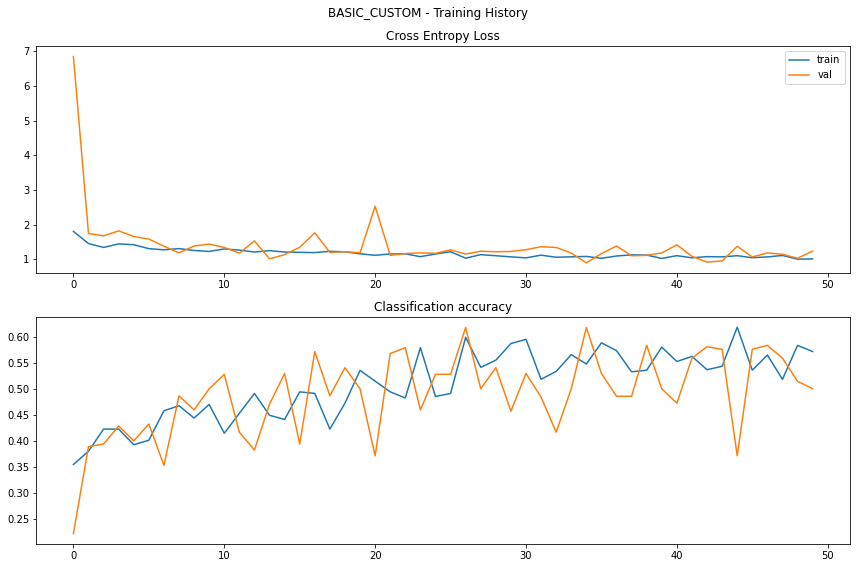

In [20]:
fig = plot_training_history(train_history=train_history, val_history=val_history, model_name=MODEL_NAME, phase_name="Training", out_dir=OUT_DIR)
fig.show()

Clear GPU memory for guarantees

In [27]:
import gc
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info(device)

(2915211675, 4294836224)

In [28]:
!nvidia-smi

Fri Jun 10 12:06:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.95       Driver Version: 512.95       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8    N/A /  N/A |    638MiB /  4096MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Fine-tune the model

Load best model from first training session

In [29]:
BATCH_SIZE = 8 # Have to reduce batch size otherwise GPU memory dies (tested on 1050TI with 4GB)

train_dataloader = DataLoader(
    dataset=training_data,
    sampler=train_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False, # Must be False because we're using a random sampler already
    drop_last=True,
    collate_fn=training_data.collate_fn
)

val_dataloader = DataLoader(
    dataset=training_data,
    sampler=val_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False, # Must be False because we're using a random sampler already
    drop_last=True,
    collate_fn=training_data.collate_fn
)

In [30]:
best_checkpoint = torch.load(f"{OUT_DIR}/{MODEL_NAME}_best_model.pth")
model = get_model()
model.load_state_dict(best_checkpoint["model"])
best_checkpoint = None

model.to(device)


print("Loaded best model...")

Loaded best model...


In [31]:
ft_optimizer = optim.Adam(
    params=model.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999),
    weight_decay=5e-4,
    amsgrad=True
)

ft_lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=ft_optimizer,
    gamma=0.99
)

In [32]:
FT_NUM_EPOCHS = 30
#model.features.requires_grad_(True) # Unfreeze feature layer for fine-tuning

ft_train_history = {
    "loss": [],
    "accuracy": [],
}

ft_val_history = {
    "loss": [],
    "accuracy": [],
}

ft_best_val_loss = best_val_loss
ft_best_val_accuracy = best_val_accuracy
ft_best_epoch = -1

print(f"Starting {MODEL_NAME} fine-tuning...")

for epoch in range(1, FT_NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{FT_NUM_EPOCHS}]")
    (train_target, train_preds, train_probs, _), train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device,
        is_train=True,
        optimizer=ft_optimizer,
        lr_scheduler=ft_lr_scheduler
    )

    train_accuracy = metric_scorer(torch.tensor(np.array(train_probs)), torch.tensor(np.array(train_target))).item()
    print(f"Training loss: {train_loss:.3f}\t Training micro accuracy: {train_accuracy:.3f}")

    (val_target, val_preds, val_probs, _), val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device,
        is_train=False,
    )

    val_accuracy = metric_scorer(torch.tensor(np.array(val_probs)), torch.tensor(np.array(val_target))).item()
    print(f"Validation loss: {val_loss:.3f}\t Validation micro accuracy: {val_accuracy:.3f}")

    # Save best model
    if val_loss < ft_best_val_loss:
        ft_best_val_loss = val_loss
        ft_best_val_accuracy = val_accuracy
        ft_best_epoch = epoch
        save_dict = {"model": model.state_dict(), "optimizer": ft_optimizer.state_dict(), "lr_scheduler": ft_lr_scheduler.state_dict(), "epoch": epoch}
        torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_ft_best_model.pth")

    # Save latest model
    save_dict = {"model": model.state_dict(), "optimizer": ft_optimizer.state_dict(), "lr_scheduler": ft_lr_scheduler.state_dict(), "epoch": epoch}
    torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_ft_latest_model.pth")

    # Save loss and accuracy in history
    ft_train_history["loss"].append(train_loss)
    ft_train_history["accuracy"].append(train_accuracy)

    ft_val_history["loss"].append(val_loss)
    ft_val_history["accuracy"].append(val_accuracy)

    print("----------------------------------------------------------------")

print(
    f"\nFinished fine-tuning..."
    f"\nBest epoch: {ft_best_epoch}\t Validation loss on best epoch: {ft_best_val_loss}\t Accuracy on best epoch: {ft_best_val_accuracy}"
)

Starting BASIC_CUSTOM fine-tuning...
Epoch[1/30]


100%|██████████| 23/23 [00:13<00:00,  1.68it/s]


Training loss: 1.005	 Training micro accuracy: 0.637


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Validation loss: 1.203	 Validation micro accuracy: 0.588
----------------------------------------------------------------
Epoch[2/30]


100%|██████████| 23/23 [00:14<00:00,  1.56it/s]


Training loss: 1.073	 Training micro accuracy: 0.560


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Validation loss: 1.046	 Validation micro accuracy: 0.529
----------------------------------------------------------------
Epoch[3/30]


100%|██████████| 23/23 [00:14<00:00,  1.61it/s]


Training loss: 1.098	 Training micro accuracy: 0.533


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Validation loss: 1.377	 Validation micro accuracy: 0.500
----------------------------------------------------------------
Epoch[4/30]


100%|██████████| 23/23 [00:14<00:00,  1.60it/s]


Training loss: 0.997	 Training micro accuracy: 0.587


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Validation loss: 1.310	 Validation micro accuracy: 0.595
----------------------------------------------------------------
Epoch[5/30]


100%|██████████| 23/23 [00:14<00:00,  1.62it/s]


Training loss: 1.026	 Training micro accuracy: 0.606


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Validation loss: 1.138	 Validation micro accuracy: 0.529
----------------------------------------------------------------
Epoch[6/30]


100%|██████████| 23/23 [00:15<00:00,  1.45it/s]


Training loss: 0.958	 Training micro accuracy: 0.647


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Validation loss: 1.301	 Validation micro accuracy: 0.514
----------------------------------------------------------------
Epoch[7/30]


100%|██████████| 23/23 [00:14<00:00,  1.54it/s]


Training loss: 1.052	 Training micro accuracy: 0.565


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Validation loss: 1.362	 Validation micro accuracy: 0.514
----------------------------------------------------------------
Epoch[8/30]


100%|██████████| 23/23 [00:14<00:00,  1.59it/s]


Training loss: 1.036	 Training micro accuracy: 0.567


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Validation loss: 1.234	 Validation micro accuracy: 0.528
----------------------------------------------------------------
Epoch[9/30]


100%|██████████| 23/23 [00:14<00:00,  1.63it/s]


Training loss: 1.063	 Training micro accuracy: 0.580


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Validation loss: 1.127	 Validation micro accuracy: 0.541
----------------------------------------------------------------
Epoch[10/30]


100%|██████████| 23/23 [00:14<00:00,  1.61it/s]


Training loss: 0.962	 Training micro accuracy: 0.600


100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation loss: 1.029	 Validation micro accuracy: 0.611
----------------------------------------------------------------
Epoch[11/30]


100%|██████████| 23/23 [00:15<00:00,  1.47it/s]


Training loss: 0.959	 Training micro accuracy: 0.653


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Validation loss: 0.971	 Validation micro accuracy: 0.571
----------------------------------------------------------------
Epoch[12/30]


100%|██████████| 23/23 [00:15<00:00,  1.53it/s]


Training loss: 0.935	 Training micro accuracy: 0.636


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Validation loss: 0.860	 Validation micro accuracy: 0.632
----------------------------------------------------------------
Epoch[13/30]


100%|██████████| 23/23 [00:15<00:00,  1.47it/s]


Training loss: 0.984	 Training micro accuracy: 0.596


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Validation loss: 1.126	 Validation micro accuracy: 0.576
----------------------------------------------------------------
Epoch[14/30]


100%|██████████| 23/23 [00:14<00:00,  1.61it/s]


Training loss: 1.004	 Training micro accuracy: 0.588


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Validation loss: 1.555	 Validation micro accuracy: 0.486
----------------------------------------------------------------
Epoch[15/30]


100%|██████████| 23/23 [00:18<00:00,  1.26it/s]


Training loss: 0.990	 Training micro accuracy: 0.593


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation loss: 1.214	 Validation micro accuracy: 0.611
----------------------------------------------------------------
Epoch[16/30]


100%|██████████| 23/23 [00:15<00:00,  1.51it/s]


Training loss: 0.911	 Training micro accuracy: 0.627


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Validation loss: 1.440	 Validation micro accuracy: 0.472
----------------------------------------------------------------
Epoch[17/30]


100%|██████████| 23/23 [00:15<00:00,  1.50it/s]


Training loss: 0.935	 Training micro accuracy: 0.608


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Validation loss: 1.261	 Validation micro accuracy: 0.545
----------------------------------------------------------------
Epoch[18/30]


100%|██████████| 23/23 [00:14<00:00,  1.59it/s]


Training loss: 0.955	 Training micro accuracy: 0.618


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Validation loss: 1.014	 Validation micro accuracy: 0.486
----------------------------------------------------------------
Epoch[19/30]


100%|██████████| 23/23 [00:14<00:00,  1.63it/s]


Training loss: 1.039	 Training micro accuracy: 0.600


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Validation loss: 1.272	 Validation micro accuracy: 0.472
----------------------------------------------------------------
Epoch[20/30]


100%|██████████| 23/23 [00:13<00:00,  1.65it/s]


Training loss: 0.960	 Training micro accuracy: 0.627


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Validation loss: 1.327	 Validation micro accuracy: 0.556
----------------------------------------------------------------
Epoch[21/30]


100%|██████████| 23/23 [00:14<00:00,  1.63it/s]


Training loss: 0.974	 Training micro accuracy: 0.642


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Validation loss: 1.037	 Validation micro accuracy: 0.579
----------------------------------------------------------------
Epoch[22/30]


100%|██████████| 23/23 [00:14<00:00,  1.61it/s]


Training loss: 0.930	 Training micro accuracy: 0.641


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Validation loss: 1.060	 Validation micro accuracy: 0.649
----------------------------------------------------------------
Epoch[23/30]


100%|██████████| 23/23 [00:14<00:00,  1.54it/s]


Training loss: 1.041	 Training micro accuracy: 0.556


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Validation loss: 1.112	 Validation micro accuracy: 0.576
----------------------------------------------------------------
Epoch[24/30]


100%|██████████| 23/23 [00:16<00:00,  1.36it/s]


Training loss: 1.024	 Training micro accuracy: 0.607


100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


Validation loss: 1.133	 Validation micro accuracy: 0.588
----------------------------------------------------------------
Epoch[25/30]


100%|██████████| 23/23 [00:18<00:00,  1.25it/s]


Training loss: 0.972	 Training micro accuracy: 0.611


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


Validation loss: 0.947	 Validation micro accuracy: 0.556
----------------------------------------------------------------
Epoch[26/30]


100%|██████████| 23/23 [00:18<00:00,  1.26it/s]


Training loss: 0.976	 Training micro accuracy: 0.614


100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


Validation loss: 1.445	 Validation micro accuracy: 0.529
----------------------------------------------------------------
Epoch[27/30]


100%|██████████| 23/23 [00:17<00:00,  1.33it/s]


Training loss: 0.940	 Training micro accuracy: 0.637


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Validation loss: 1.114	 Validation micro accuracy: 0.606
----------------------------------------------------------------
Epoch[28/30]


100%|██████████| 23/23 [00:16<00:00,  1.36it/s]


Training loss: 0.983	 Training micro accuracy: 0.641


100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


Validation loss: 1.096	 Validation micro accuracy: 0.588
----------------------------------------------------------------
Epoch[29/30]


100%|██████████| 23/23 [00:18<00:00,  1.26it/s]


Training loss: 1.017	 Training micro accuracy: 0.595


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Validation loss: 1.092	 Validation micro accuracy: 0.568
----------------------------------------------------------------
Epoch[30/30]


100%|██████████| 23/23 [00:15<00:00,  1.50it/s]


Training loss: 0.957	 Training micro accuracy: 0.628


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]

Validation loss: 1.174	 Validation micro accuracy: 0.576
----------------------------------------------------------------

Finished fine-tuning...
Best epoch: 12	 Validation loss on best epoch: 0.8603929162025452	 Accuracy on best epoch: 0.6315789222717285


C:\Users\telmo\AppData\Local\Temp/ipykernel_8876/1559553078.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


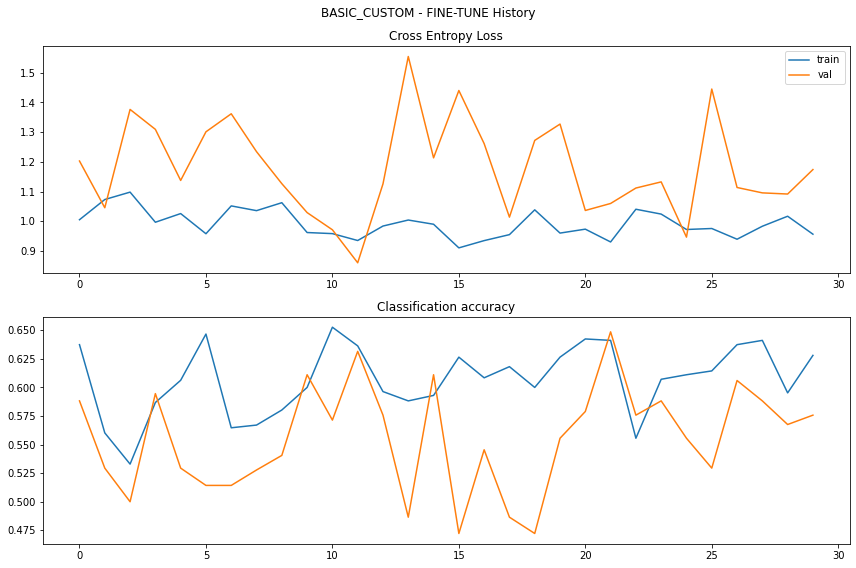

In [33]:
fig = plot_training_history(train_history=ft_train_history, val_history=ft_val_history, model_name=MODEL_NAME, phase_name="FINE-TUNE", out_dir=OUT_DIR)
fig.show()

Clean GPU memory again

In [34]:
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info(device)

(2885851547, 4294836224)

# Test the model

In [35]:
best_checkpoint = torch.load(f"{OUT_DIR}/{MODEL_NAME}_ft_best_model.pth")
model = get_model()
model.load_state_dict(best_checkpoint["model"])
best_checkpoint = None

model.to(device)


print("Loaded best fine-tuned model...")

Loaded best fine-tuned model...


In [36]:
(test_target, test_preds, test_probs, test_ids), test_loss = epoch_iter(
    dataloader=test_dataloader,
    model=model,
    loss_fn=loss_fn,
    device=device,
    is_train=False,
)

100%|██████████| 264/264 [00:14<00:00, 17.99it/s]


In [37]:
test_metrics = torchmetrics.MetricCollection(
    metrics={
        "micro_accuracy": metric_scorer,
        "macro_accuracy": torchmetrics.Accuracy(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="macro",
        ),
        "weighted_accuracy": torchmetrics.Accuracy(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="weighted",
        ),
        "micro_f1_score": torchmetrics.F1Score(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="micro",
        ),
        "macro_f1_score": torchmetrics.F1Score(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="macro",
        ),
        "weighted_f1_score": torchmetrics.F1Score(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="weighted",
        )
    }
)

test_probs_tensor = torch.tensor(np.array(test_probs))
test_target_tensor = torch.tensor(np.array(test_target))

test_metrics_scores = test_metrics(test_probs_tensor, test_target_tensor)

print(test_metrics_scores)

{'macro_accuracy': tensor(0.5416), 'macro_f1_score': tensor(0.5483), 'micro_accuracy': tensor(0.7576), 'micro_f1_score': tensor(0.7576), 'weighted_accuracy': tensor(0.7576), 'weighted_f1_score': tensor(0.7524)}


In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_true=test_target, y_pred=test_preds, target_names=list(label_encode_map.keys())[1:]))

              precision    recall  f1-score   support

trafficlight       0.42      0.54      0.47        24
  speedlimit       0.86      0.88      0.87       192
   crosswalk       0.44      0.44      0.44        25
        stop       0.64      0.30      0.41        23

    accuracy                           0.76       264
   macro avg       0.59      0.54      0.55       264
weighted avg       0.76      0.76      0.75       264



In [ ]:
from PIL import Image
def showErrors(imageIds, y_true, y_pred, limit=None, img_dir = "./"):
    N = limit if limit is not None else len(imageIds)
    N_COLS = 4
    N_ROWS = N // 4 + N % 4
    shown = 0
    fig = plt.figure(figsize=(8*N_COLS, 12*N_ROWS))
    for (imageId, correct, predicted) in zip(imageIds, y_true, y_pred):
        if correct == predicted:
            continue
        image = np.array(Image.open(f"{img_dir}/{imageId}.png").convert("RGB"))
        target_label = f"TRUE: {label_decode_map[correct]}"
        predicted_label = f"PRED: {label_decode_map[predicted]}"

        ax = fig.add_subplot(N_ROWS, N_COLS, shown + 1)
        ax.axis("off")
        ax.text(0, -8, imageId, fontsize=14, color="black")
        ax.text((len(imageId) + 1) * 8, -8, target_label, fontsize=14, color='green') # correct
        ax.text((len(imageId) + len(target_label) + 1) * 8, -8, predicted_label, fontsize=14, color='red')  # predicted
        ax.imshow(image)
        
        shown += 1

        if shown >= N:
            break

    plt.tight_layout()
    plt.show()

In [ ]:
showErrors(test_ids, test_target, test_preds, limit=None, img_dir=IMG_DIR)